<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/09-neural-networks/NNs_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

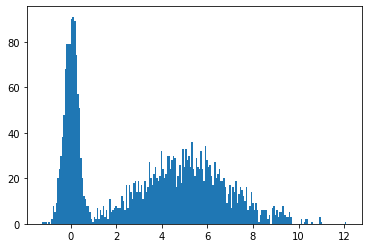

In [6]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

[[tensor([0.9171]), tensor([4.2578]), tensor([1.1443]), tensor([1.8878]), tensor([0.3850])], [tensor([0.8676]), tensor([4.3031]), tensor([1.2289]), tensor([2.0314]), tensor([0.3560])], [tensor([0.8306]), tensor([4.3360]), tensor([1.2941]), tensor([2.1534]), tensor([0.3469])], [tensor([0.8017]), tensor([4.3613]), tensor([1.3495]), tensor([2.2600]), tensor([0.3394])], [tensor([0.7785]), tensor([4.3813]), tensor([1.3985]), tensor([2.3556]), tensor([0.3326])], [tensor([0.7595]), tensor([4.3972]), tensor([1.4430]), tensor([2.4430]), tensor([0.3264])], [tensor([0.7439]), tensor([4.4100]), tensor([1.4842]), tensor([2.5239]), tensor([0.3207])], [tensor([0.7309]), tensor([4.4202]), tensor([1.5227]), tensor([2.5993]), tensor([0.3154])], [tensor([0.7202]), tensor([4.4283]), tensor([1.5591]), tensor([2.6703]), tensor([0.3106])], [tensor([0.7113]), tensor([4.4348]), tensor([1.5939]), tensor([2.7375]), tensor([0.3060])], [tensor([0.7041]), tensor([4.4398]), tensor([1.6272]), tensor([2.8013]), tensor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


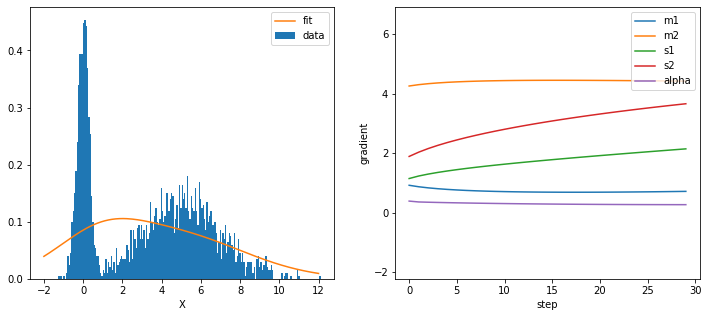

In [8]:
from types import prepare_class
from IPython.display import clear_output
import math

# Defining Gaussian PDF using torch functions
def gaussian(x, mu, sigma):
    #torch.pi = torch.acos(torch.zeros(1)).item() * 2
    #return torch.div(1, torch.sqrt(torch.pow(sigma, 2) * 2 * torch.pi)) * torch.exp(torch.tensor(torch.pow(-1/2 * (torch.tensor(x) - mu) / sigma, 2)))# use torch.exp for the exponent, don't forget the normalization
    return 1 / math.sqrt(sigma**2 * 2 * math.pi) * torch.exp(-1/2 * ((torch.tensor(x) - mu)/sigma)**2)

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
    return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = torch.tensor([1.0], requires_grad=True) #requires_grad?
m2    = torch.tensor([4.0], requires_grad=True)
s1    = torch.tensor([1.0], requires_grad=True)
s2    = torch.tensor([1.0], requires_grad=True)
alpha = torch.tensor([0.5], requires_grad=True)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
  #<YOUR CODE> # ensure the sigmas are positive (greater or equal to some small
              # positive number, e.g. 1e-5) and alpha is in (0, 1) interval
    
    torch.clamp(s1, min=1e-5)
    torch.clamp(s2, min=1e-5)
    torch.clamp(alpha, 0, 1)

variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)
    
# Log likelihood
def loglike(x): 
    
    return torch.sum(torch.log(model_pdf(x)))
    

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

for i in range(30):
  # Forward pass:
  l = loglike(X)
  #print(l)
  l.backward()

  with torch.no_grad():
        m1.add_(learning_rate * m1.grad)
        m2.add_(learning_rate * m2.grad)
        s1.add_(learning_rate * s1.grad)
        s2.add_(learning_rate * s2.grad)
        alpha.add_(learning_rate * alpha.grad)
        grad_history.append([torch.clone(m1), torch.clone(m2), torch.clone(s1), torch.clone(s2), torch.clone(alpha)])
        #grad_history.append([m1.numpy(force=True),m2.numpy(force=True),s1.numpy(force=True),s2.numpy(force=True),alpha.numpy(force=True)])
        m1.grad.zero_()
        m2.grad.zero_()
        s1.grad.zero_()
        s2.grad.zero_()
        alpha.grad.zero_()
  print(grad_history)
  #print(m1, m1.grad)
  #grad_m1 = m1.grad
  #grad_m2 = m2.grad
  #grad_s1 = s1.grad
  #grad_s2 = s2.grad
  #grad_alpha = alpha.grad
  #print(grad_m1)
  #cur_grads = [grad_m1, grad_m2, grad_s1, grad_s2, grad_alpha]
  #print(cur_grads)
  #grad_history.append(cur_grads)
  #variables += [learning_rate * x for x in cur_grads]
  # Backprop
  # Gradient ascent step
  apply_constraints()
  ############################
  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = np.linspace(-2, 12, 150)
  plt.plot(x_grid, model_pdf(x_grid).detach(), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  clear_output(wait=True);

# Task 2: classifying clothes (3 points)

In [9]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



[['Bag' 'Trouser' 'Dress' 'Dress' 'Ankle boot' 'Pullover' 'Ankle boot'
  'Trouser']
 ['Dress' 'Ankle boot' 'Dress' 'Dress' 'Sandal' 'Dress' 'T-shirt/top'
  'Trouser']
 ['Shirt' 'Bag' 'Shirt' 'Sandal' 'Sneaker' 'Trouser' 'Coat' 'Trouser']
 ['Pullover' 'Sandal' 'Shirt' 'Shirt' 'T-shirt/top' 'Sandal' 'Ankle boot'
  'T-shirt/top']
 ['Bag' 'Shirt' 'Trouser' 'Sandal' 'Sneaker' 'Bag' 'Bag' 'Sneaker']
 ['T-shirt/top' 'Coat' 'Bag' 'T-shirt/top' 'Dress' 'Bag' 'Trouser'
  'Shirt']
 ['Sneaker' 'Ankle boot' 'Sneaker' 'Sneaker' 'Sandal' 'Bag' 'Coat'
  'Ankle boot']
 ['Sandal' 'Coat' 'Trouser' 'Dress' 'Dress' 'Dress' 'Ankle boot'
  'Sneaker']]
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
        

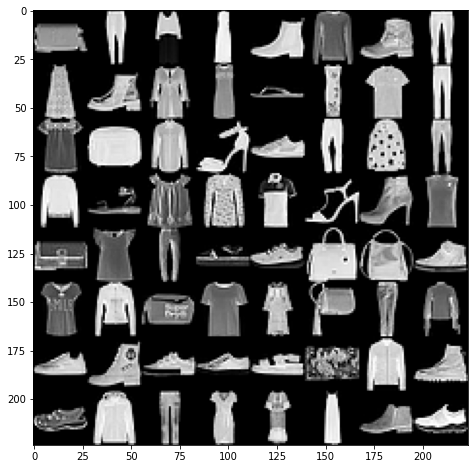

In [12]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])
print(sample_images)

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

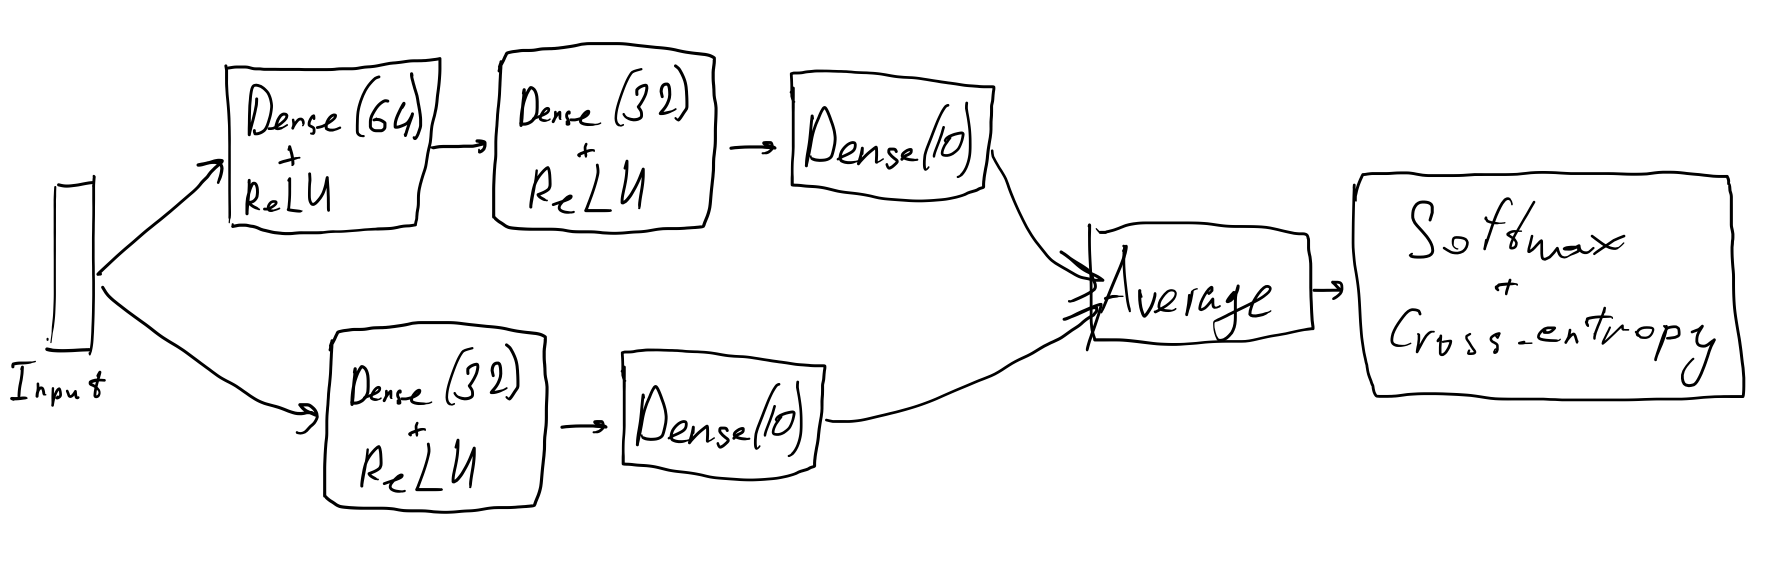

In [13]:
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F

In [14]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')

In [15]:
seq_modules_1 = nn.Sequential(
    nn.Flatten(),   
    nn.Linear(in_features=28*28, out_features=64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)

seq_modules_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)



In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.part1 = seq_modules_1
        self.part2 = seq_modules_2
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x_1 = self.part1(x)
        x_2 = self.part2(x)
        x_res = 0.5 * x_1 + 0.5 * x_2
        return self.softmax(x_res)

In [21]:
import torch.optim as optim

In [22]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
output = net(trainloader)
softmax = nn.Softmax(dim=1)
pred_probab = softmax(output)


In [28]:
net.to(my_device)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(my_device))
        loss = criterion(outputs, labels.to(my_device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(running_loss)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

1.8027927875518799
3.5997246503829956
5.44620144367218
7.176231265068054
8.948652505874634
10.793918371200562
12.610133290290833
14.342247605323792
16.182315349578857
17.95239794254303
19.74845051765442
21.51495850086212
23.31347894668579
25.063619256019592
26.87950325012207
28.61167573928833
30.361077785491943
32.18573486804962
34.02516460418701
35.74501025676727
37.57029688358307
39.37924039363861
41.16324961185455
42.90690457820892
44.625463247299194
46.399086117744446
48.19101393222809
50.03448510169983
51.87073290348053
53.689637899398804
55.500131607055664
57.31530141830444
59.07585823535919
60.8660101890564
62.643259048461914
64.45098924636841
66.23763430118561
68.13168632984161
70.04100918769836
71.7887145280838
73.57125174999237
75.33454847335815
77.0968086719513
79.02482497692108
80.81705605983734
82.50245678424835
84.35418832302094
86.17346799373627
88.00376737117767
89.7525645494461
91.54924285411835
93.42831015586853
95.24106347560883
97.0176351070404
98.79721534252167
100

In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
      # get the inputs
        inputs, labels = data

        # forward + backward + optimize
        outputs = net(inputs.to(my_device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(my_device)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 70 %
